# Analysis of Sealing Quality for Coffee Capsules

Michael P - 02/22/2025


## Introduction and project overview
This project aims to classify the quality of coffee capsule seals based on energy and force measurements collected during a controlled laboratory sealing trial.  We are addressing a supervised learning problem, specifically a multi-class classification task.  The objective is to accurately categorize seals into four distinct classes:

- 1 (good seal)
- 2 (contaminated sealing head)
- 3 (contaminated seal between foil and capsule)
- 4 (torn/wrinkled foil)

Accurate classification is essential for quality assurance in coffee capsule production, enabling the early identification of defects and minimizing production losses.


## Data
The data for this project originates from a laboratory trial conducted to assess the impact of various sealing defects on the energy and force profiles during the sealing process.  250 samples were collected for each of the four seal classes, resulting in a total dataset of 1000 samples.  The dataset comprises 10 energy measurements (energy_mp_1 to energy_mp_10) and 10 force measurements (force_mp_1 to force_mp_10) recorded for each sample, along with the corresponding seal quality class label.

## Domain knowledge input

**Hypotheses:**
- Class 2 and 3 should exhibit higher forces compared to normal seals.
- Class 2 is expected to have lower energy consumption due to contamination acting as insulation.
- Class 3 should also have lower energy consumption but higher than class 2.
- Class 3 should have a flatter force curve with a shifted peak force.

## Load Required Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

## Load and Explore Data

Load the data and rename the class column for better readability

In [ ]:
df = pd.read_csv("seal_quality.csv", delimiter=';')

### Data check and cleaning

In [7]:
# Rename the class column for better readability
df.rename(columns={'DefectCauseClass': 'class'}, inplace=True)

# general
print(df.info())
print(df.describe())
print(df.head())

# missing values
print("\nMissing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   class         1000 non-null   int64  
 1   energy_mp_1   1000 non-null   float64
 2   energy_mp_2   1000 non-null   float64
 3   energy_mp_3   1000 non-null   float64
 4   energy_mp_4   1000 non-null   float64
 5   energy_mp_5   1000 non-null   float64
 6   energy_mp_6   1000 non-null   float64
 7   energy_mp_7   1000 non-null   float64
 8   energy_mp_8   1000 non-null   float64
 9   energy_mp_9   1000 non-null   float64
 10  energy_mp_10  1000 non-null   float64
 11  force_mp_1    1000 non-null   float64
 12  force_mp_2    1000 non-null   float64
 13  force_mp_3    1000 non-null   float64
 14  force_mp_4    1000 non-null   float64
 15  force_mp_5    1000 non-null   float64
 16  force_mp_6    1000 non-null   float64
 17  force_mp_7    1000 non-null   float64
 18  force_mp_8    1000 non-null  

No missing values were detected in this dataset. This is likely due to the controlled nature of the lab trial. In real-world production settings, missing data would be a common issue and would require appropriate handling, such as imputation or removal, depending on the context.

## Exploratory Data Analysis (EDA) 

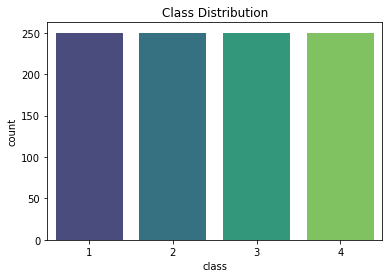

In [8]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Class Distribution')
plt.show()


The class distribution is balanced, with 250 samples per class. This balanced distribution is ideal for training a robust classification model, as it prevents bias towards any particular class.

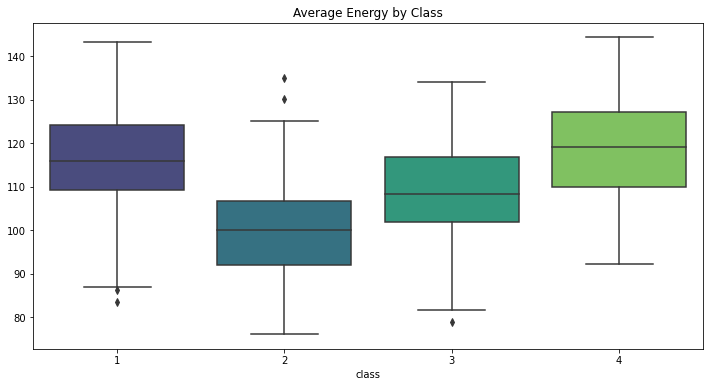

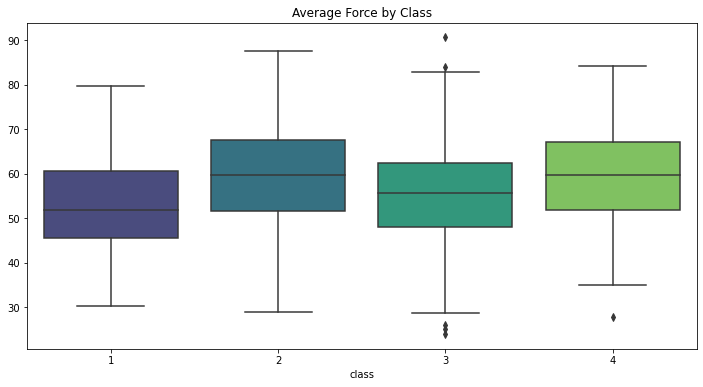

In [9]:
# Boxplots for force and energy by class
energy_cols = [col for col in df.columns if "energy_mp_" in col]
force_cols = [col for col in df.columns if "force_mp_" in col]

plt.figure(figsize=(12,6))
sns.boxplot(x='class', y=df[energy_cols].mean(axis=1), data=df, palette='viridis')
plt.title('Average Energy by Class')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='class', y=df[force_cols].mean(axis=1), data=df, palette='viridis')
plt.title('Average Force by Class')
plt.show()

These boxplots provide a preliminary visualization of the distribution of average energy and force values across the different seal classes.  They reveal potential differences in the central tendency and variability of these measurements for each class.

###  Individual plots for energy and force curves per class (first 50 samples for visualization)

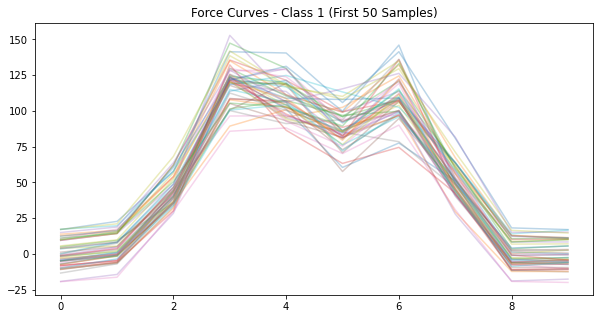

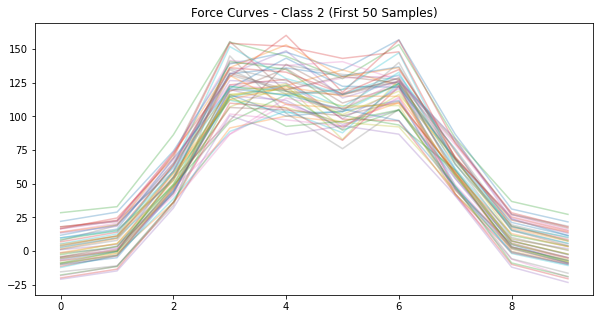

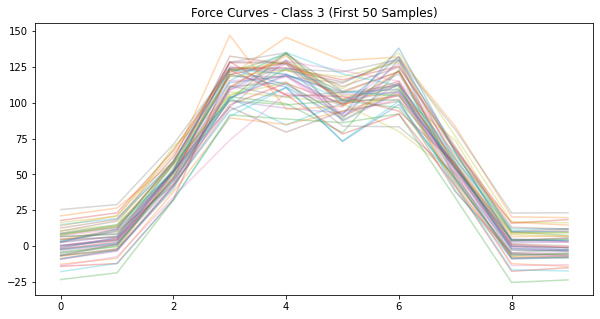

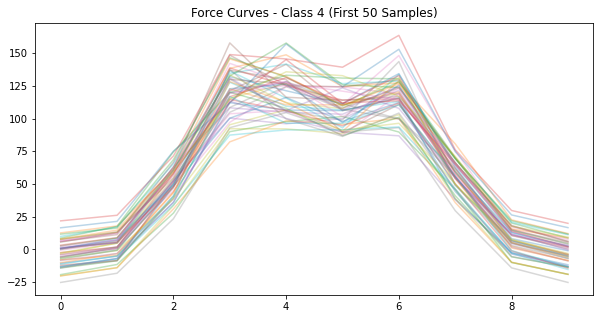

In [10]:
# analyse force curves
for label, group in df.groupby("class"):
    plt.figure(figsize=(10,5))
    plt.plot(group[force_cols].values[:50].T, alpha=0.3)
    plt.title(f'Force Curves - Class {label} (First 50 Samples)')
    plt.show()

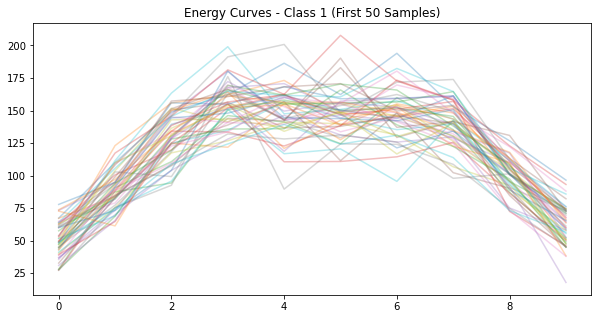

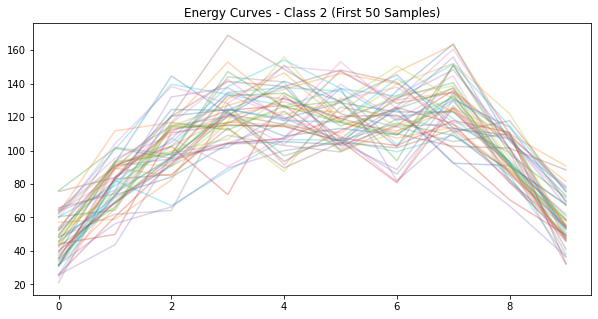

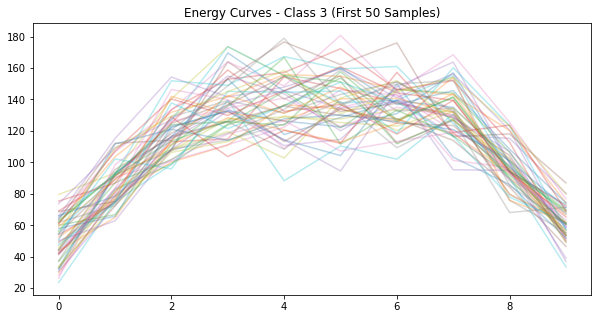

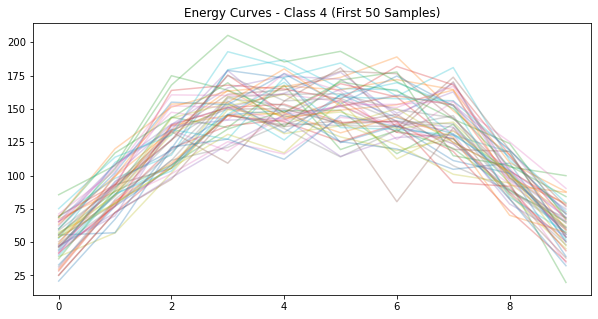

In [11]:
# analyse energy curves
for label, group in df.groupby("class"):
    plt.figure(figsize=(10,5))
    plt.plot(group[energy_cols].values[:50].T, alpha=0.3)
    plt.title(f'Energy Curves - Class {label} (First 50 Samples)')
    plt.show()

These plots display the individual energy and force curves for the first 50 samples of each class, showing the evolution of these measurements over the 10 measurement points.  Visualizing these curves helps to understand the characteristic patterns associated with each seal class and informs feature selection for the classification model.

## Model development

In [12]:
# Feature selection and data preprocessing
X = df.drop(columns=['class'])  # Features (energy and force measurements)
y = df['class']  # Target variable (seal class)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42) # Use the scaled data

# Model training (Random Forest)
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced') # Increased n_estimators, added class_weight
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


## Results and Evaluation

Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.73      0.67        44
           2       0.87      0.79      0.83        52
           3       0.76      0.58      0.66        55
           4       0.73      0.90      0.81        49

    accuracy                           0.74       200
   macro avg       0.75      0.75      0.74       200
weighted avg       0.75      0.74      0.74       200

Confusion Matrix:


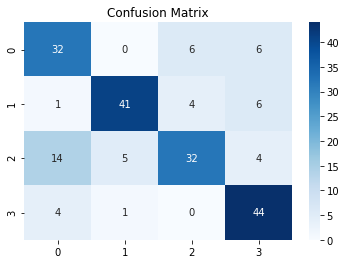

Accuracy: 0.745


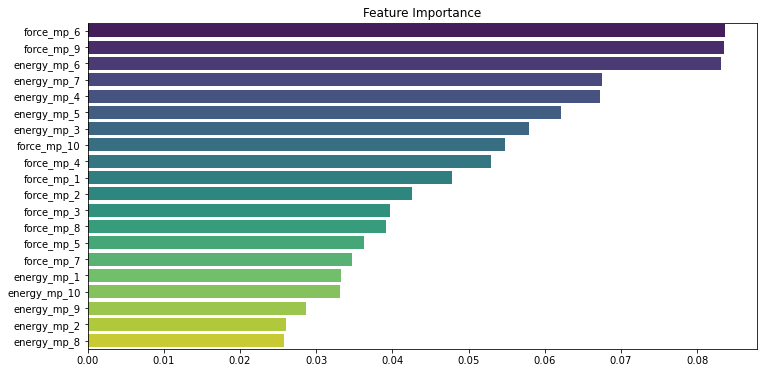

In [14]:
# Model evaluation function
def evaluate_model(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    return accuracy

accuracy = evaluate_model(y_test, y_pred)


# Feature Importance
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title("Feature Importance")
plt.show()

## Discussion and Conclusion

The Random Forest model achieved a reasonable accuracy of 74.5% in classifying coffee capsule seals based on the energy and force measurements collected during the lab trial.  While this indicates that the measurements contain useful information for distinguishing between seal classes, there's room for improvement.  The classification report provides a more granular view of the model's performance.  We can see that class 2 (contaminated sealing head) has the highest precision (87%) and a good recall (79%), suggesting the model is quite good at identifying this defect. Class 4 (torn/wrinkled foil) also performs well, with high recall (90%) but slightly lower precision (73%). Classes 1 (good seal) and 3 (contaminated seal) show lower performance, particularly class 3, which has a recall of only 58%. This suggests the model struggles to correctly identify contaminated seals and sometimes confuses them with other classes.

The confusion matrix provides valuable insights into the specific types of misclassifications occurring. 
We observe that class 0 (good seal) is often confused with classes 2 and 3, potentially indicating similarities in the energy and force profiles for these seal types. 
- Class 1 (contaminated sealing head) shows relatively good performance, with most misclassifications occurring with class 3 (torn/wrinkled foil). 
- Class 2 (contaminated seal) exhibits the most significant challenges, being frequently confused with class 0 and to a lesser extent with class 1.
This suggests that the model struggles to consistently differentiate contaminated seals from good seals or seals with contaminated heads. 
- Class 3 (torn/wrinkled foil) demonstrates strong performance, with the majority of samples correctly classified.


The feature importance analysis reveals that force measurements at point 6 (`force_mp_6`) and point 9 (`force_mp_9`), along with energy measurements at points 6, 7, 4, and 5 (`energy_mp_6`, `energy_mp_7`, `energy_mp_4`, `energy_mp_5`), are the most influential in determining seal quality.  This suggests that the forces and energy exerted during these specific stages of the sealing process are particularly indicative of the presence and type of defects.  The prominence of both force and energy measurements highlights the importance of considering both types of data for accurate seal classification.


Future research could explore several avenues for improvement:

*   **Addressing Class Imbalance:** While the initial dataset was balanced, the model may still be exhibiting some bias.  Techniques like oversampling the underperforming classes or using cost-sensitive learning could be explored.
*   **Feature Engineering:** Creating new features from the existing ones (e.g., ratios of energy to force, differences between measurement points) might improve the model's ability to discriminate between classes.
*   **Model Tuning:** Experimenting with different hyperparameters for the Random Forest (e.g., `max_depth`, `min_samples_split`) or trying other classification algorithms (Gradient Boosting, Support Vector Machines, etc.) could lead to better performance.
*   **Data Augmentation:** If possible, collecting more data, especially for the underperforming classes, would likely be beneficial.  If additional data is hard to obtain, data augmentation techniques might be explored.
*   **Error Analysis:** A more in-depth analysis of the misclassified samples could reveal specific patterns or characteristics that are causing the model to struggle. This could inform feature engineering or data collection strategies.

While the current model provides a starting point for seal quality classification, further investigation and refinement are needed to achieve robust and reliable performance in a real-world production environment.
